In [1]:
# ignore warning 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob
import numpy as np

In [ ]:
# import os
# import matplotlib.pyplot as plt
# from PIL import Image

# data_path = "/kaggle/input/dataset-license/data/data/train"
# classes = [str(i) for i in range(10)] + [chr(65 + i) for i in range(26)]
# rows, cols = 6, 6
# output_file = "Data_sample.png"
# dpi = 600
# border_color = 'white'
# border_width = 1


# fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
# for i, ax in enumerate(axes.flat):
#     class_folder = os.path.join(data_path, "class_"+classes[i])
#     image_files = os.listdir(class_folder)
#     sample_image_path = os.path.join(class_folder, image_files[0])
#     sample_image = Image.open(sample_image_path)
    
#     ax.imshow(sample_image, cmap='gray')  # Assuming the images are grayscale
#     ax.set_xticks([])  # Remove x-axis ticks
#     ax.set_yticks([])  # Remove y-axis ticks
    
#     # Adding a white border
#     sample_image_border = Image.new('RGB', sample_image.size, border_color)
#     sample_image_border.paste(sample_image, (border_width, border_width))
    
#     ax.imshow(sample_image_border, aspect='auto')

# plt.tight_layout(pad=0)
# plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig(output_file, dpi=dpi, bbox_inches="tight")
# plt.show()


In [ ]:
# import os

# main_folder_path = '/kaggle/input/dataset-characters/dataset_characters'
# total_file_count = 0

# for root, dirs, files in os.walk(main_folder_path):
#     total_file_count += len(files)

# print(f"Total number of files in the main folder and its subfolders: {total_file_count}")


37623
[ 6558  6012 12895 16317 32469 36472  8054  7349 15740 35857 35302 23166]


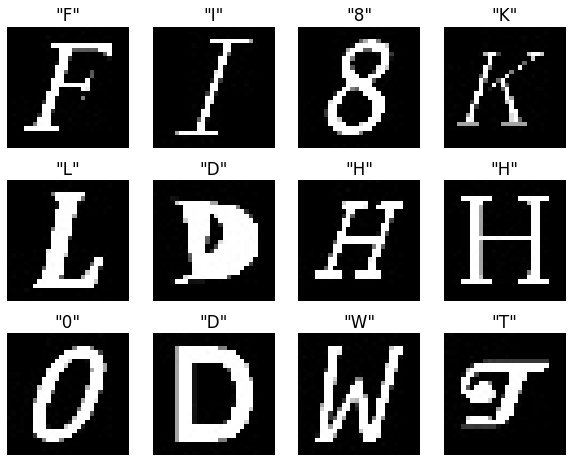

In [2]:
dataset_paths = glob.glob("../input/dataset-characters/dataset_characters/**/*.jpg")

cols=4
rows=3
fig = plt.figure(figsize=(10,8))
plt.rcParams.update({"font.size":14})
grid = gridspec.GridSpec(ncols=cols,nrows=rows,figure=fig)

# create a random list of images will be displayed
np.random.seed(45)
print(len(dataset_paths))
rand = np.random.randint(0,len(dataset_paths),size=(cols*rows))
print(rand)
# Plot image
for i in range(cols*rows):
    fig.add_subplot(grid[i])
    image = load_img(dataset_paths[rand[i]])
    label = dataset_paths[rand[i]].split(os.path.sep)[-2]
    plt.title('"{:s}"'.format(label))
    plt.axis(False)
    plt.imshow(image)

plt.savefig("Visualize_dataset.jpg",dpi=300)    

In [5]:
# Arange input data and corresponding labels
X=[]
labels=[]

for image_path in dataset_paths:
  label = image_path.split(os.path.sep)[-2]
  image=load_img(image_path,target_size=(80,80))
  image=img_to_array(image)

  X.append(image)
  labels.append(label)

In [6]:
X = np.array(X,dtype="float16")
labels = np.array(labels)

print("[INFO] Find {:d} images with {:d} classes".format(len(X),len(set(labels))))

[INFO] Find 37623 images with 36 classes


In [7]:
# perform one-hot encoding on the labels
lb = LabelEncoder()
lb.fit(labels)
labels = lb.transform(labels)
y = to_categorical(labels)

# save label file so we can use in another script
np.save('license_character_classes.npy', lb.classes_)

In [8]:
# split 10% of data as validation set
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size=0.10, stratify=y, random_state=42)


In [9]:
# data augumentation
image_gen = ImageDataGenerator(rotation_range=10,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              zoom_range=0.1,
                              fill_mode="nearest"
                              )

In [10]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [8]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [11]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers import AveragePooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def create_model(lr=1e-4, decay=1e-4/25, training=False, output_shape=y.shape[1]):
    baseModel = EfficientNetB7(weights="imagenet", 
                                include_top=False,
                                input_tensor=Input(shape=(80, 80, 3)))

    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(output_shape, activation="softmax")(headModel)
    
    model = Model(inputs=baseModel.input, outputs=headModel)
    
    if training:
        # Define trainable layers
        for layer in baseModel.layers:
            layer.trainable = True
        # Compile model
        optimizer = Adam(lr=lr, decay=decay)
        model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['acc', f1_m, precision_m, recall_m])
        
    return model


In [12]:
# initilaize initial hyperparameter
INIT_LR = 1e-4
EPOCHS = 25

model = create_model(lr=INIT_LR, decay=INIT_LR/EPOCHS,training=True)

258080768/258076736 [==============================] - 2s 0us/step


In [ ]:
BATCH_SIZE = 64

my_checkpointer = [
                EarlyStopping(monitor='val_loss', patience=5, verbose=0),
                ModelCheckpoint(filepath="EfficientNetB7_License_character_recognition.h5", verbose=1, save_weights_only=True)
                ]

result = model.fit(image_gen.flow(trainX, trainY, batch_size=BATCH_SIZE), 
                   steps_per_epoch=len(trainX) // BATCH_SIZE, 
                   validation_data=(testX, testY), 
                   validation_steps=len(testX) // BATCH_SIZE, 
                   epochs=EPOCHS, callbacks=my_checkpointer)

Epoch 1/25
529/529 [==============================] - 269s 431ms/step - loss: 1.9599 - acc: 0.4931 - f1_m: 0.4147 - precision_m: 0.6448 - recall_m: 0.3561 - val_loss: 0.2004 - val_acc: 0.9463 - val_f1_m: 0.9511 - val_precision_m: 0.9723 - val_recall_m: 0.9310

Epoch 00001: saving model to EfficientNetB7_License_character_recognition.h5
Epoch 2/25
166/529 [========>.....................] - ETA: 2:28 - loss: 0.2845 - acc: 0.9240 - f1_m: 0.9272 - precision_m: 0.9571 - recall_m: 0.8994

In [ ]:
fig = plt.figure(figsize=(14,5))
grid=gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(result.history['acc'], label='training accuracy')
plt.plot(result.history['val_acc'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()



plt.savefig("Accuracy_Loss.jpg",dpi=600)

In [ ]:
fig = plt.figure(figsize=(14,5))
grid=gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(result.history['f1_m'], label='training f1score')
plt.plot(result.history['val_f1_m'], label='val f1score')
plt.title('F1 score')
plt.xlabel('epochs')
plt.ylabel('f1 score')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(result.history['precision_m'], label='train precision')
plt.plot(result.history['val_precision_m'], label='val precision')
plt.title('Precision')
plt.xlabel('epochs')
plt.ylabel('precision')
plt.legend()

plt.savefig("F1_score_precison.jpg",dpi=600)

In [ ]:
fig = plt.figure(figsize=(14,5))
grid=gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(result.history['recall_m'], label='train recall')
plt.plot(result.history['val_recall_m'], label='val recall')
plt.title('Recall')
plt.xlabel('epochs')
plt.ylabel('recall')
plt.legend()

plt.savefig("Recall.jpg",dpi=600)

In [31]:
pip install openpyxl


     |████████████████████████████████| 249 kB 12.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [32]:
import pandas as pd
metrics_dict = {
    'training_accuracy': result.history['acc'],
    'validation_accuracy': result.history['val_acc'],
    'training_loss': result.history['loss'],
    'validation_loss': result.history['val_loss'],
    'training_f1': result.history['f1_m'],
    'validation_f1': result.history['val_f1_m'],
    'training_precision': result.history['precision_m'],
    'validation_precision': result.history['val_precision_m'],
    'training_recall': result.history['recall_m'],
    'validation_recall': result.history['val_recall_m']
}

metrics_df = pd.DataFrame(metrics_dict)

metrics_excel_filename = "EfficientNetB_training_metrics.xlsx"
metrics_df.to_excel(metrics_excel_filename, index=False)
print(f"Training metrics saved to {metrics_excel_filename}")

Training metrics saved to EfficientNetB_training_metrics.xlsx


In [14]:
# save model architectur as json file
model_json = model.to_json()
with open("EfficientNetB7_character_recognition.json", "w") as json_file:
  json_file.write(model_json)

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
plate_cascade = cv2.CascadeClassifier('../input/ai-indian-license-plate-recognition-data/indian_license_plate.xml')

In [19]:
def detect_plate(img, text=''): # the function detects and perfors blurring on the number plate.
    plate_img = img.copy()
    roi = img.copy()
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.2, minNeighbors = 7) # detects numberplates and returns the coordinates and dimensions of detected license plate's contours.
    for (x,y,w,h) in plate_rect:
        roi_ = roi[y:y+h, x:x+w, :] # extracting the Region of Interest of license plate for blurring.
        plate = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plate_img, (x+2,y), (x+w-3, y+h-5), (51,181,155), 3) # finally representing the detected contours by drawing rectangles around the edges.
    if text!='':
        plate_img = cv2.putText(plate_img, text, (x-w//2,y-h//2), 
                                cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.5, (51,181,155), 1, cv2.LINE_AA)
        
    return plate_img, plate # returning the processed image.
# Testing the above function
def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

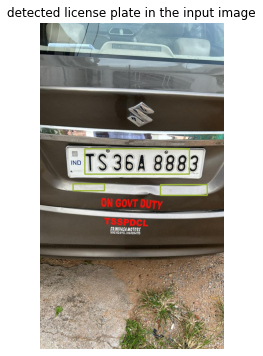

In [21]:
img = cv2.imread('/kaggle/input/test-image/IMG-20230809-WA0000.jpg')
# Getting plate prom the processed image
output_img, plate = detect_plate(img)
display(output_img, 'detected license plate in the input image')

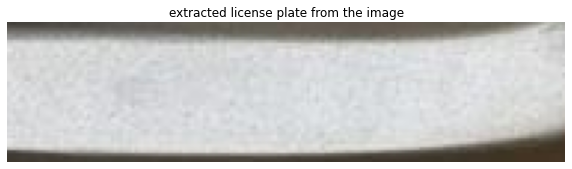

In [22]:
display(plate, 'extracted license plate from the image')

In [20]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

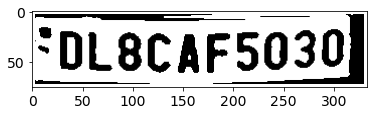

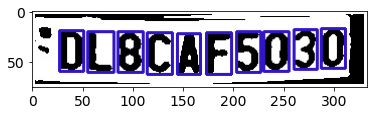

In [21]:
# Let's see the segmented characters
char = segment_characters(plate)

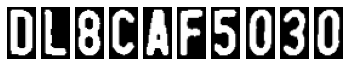

In [22]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

In [14]:
import matplotlib.gridspec as gridspec
# from local_utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
import glob

In [15]:
json_file = open('./Resnet_character_recognition.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("./License_character_recognition.h5")
print("[INFO] Model loaded successfully...")

labels = LabelEncoder()
labels.classes_ = np.load('./license_character_classes.npy')
print("[INFO] Labels loaded successfully...")

[INFO] Model loaded successfully...


NameError: name 'np' is not defined

In [13]:
# model.summary()

In [ ]:
# pre-processing input images and pedict with model
def predict_from_model(image,model,labels):
    image = cv2.resize(image,(80,80))
    image = np.stack((image,)*3, axis=-1)
    prediction = labels.inverse_transform([np.argmax(model.predict(image[np.newaxis,:]))])
    return prediction

DL8CAF5030


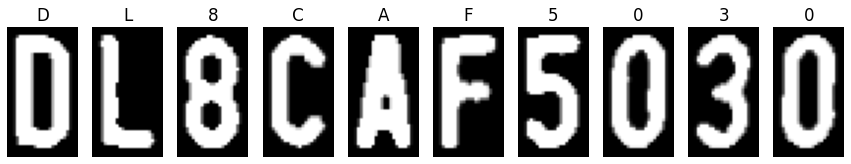

In [27]:
fig = plt.figure(figsize=(15,3))
cols = len(char)
grid = gridspec.GridSpec(ncols=cols,nrows=1,figure=fig)

final_string = ''
for i,character in enumerate(char):
    fig.add_subplot(grid[i])
    title = np.array2string(predict_from_model(character,model,labels))
    plt.title('{}'.format(title.strip("'[]"),fontsize=20))
    final_string+=title.strip("'[]")
    plt.axis(False)
    plt.imshow(character,cmap='gray')

print(final_string)

In [ ]:
import zipfile
import os
from IPython.display import FileLink

def zip_folder(folder_path, output_path):
    with zipfile.ZipFile(output_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, folder_path))

# Replace the paths with your specific folder and output zip file paths
folder_to_zip = '/kaggle/working'
output_zip_file = '/kaggle/working/my_folder.zip'

zip_folder(folder_to_zip, output_zip_file)
FileLink(output_zip_file)